In [91]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
import numpy as np
import pandas as pd


In [51]:
data = pd.read_excel('AirQualityUCI.xlsx')

# Convert 'Date' and 'Time' to string type if they aren't already
data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)

# Convert date and time to datetime with the correct format
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S')
data.set_index('DateTime', inplace=True)
data.drop(['Date', 'Time'], axis = 1, inplace = True)
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
2005-04-04 11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
2005-04-04 12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649


In [52]:
# Data Preparation
data = data.replace(-200, np.nan)  # replace -200 with NaN
data = data.interpolate()  # fill missing values

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
X_data = data.drop(columns=['CO(GT)'])
y_data = data['CO(GT)']

In [53]:
# 3. Create sequences
def create_sequences(X_data, y_data, seq_length):
    xs = []
    ys = []
    for i in range(len(X)-seq_length):
        x = X_data.iloc[i:i+seq_length].values
        y = y_data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # for example, use the last 24 hours of data to predict the next hour
X, y = create_sequences(X_data, y_data, seq_length)
X, y

(array([[[0.51184919, 0.12098139, 0.184498  , ..., 0.33333333,
          0.49905721, 0.28004639],
         [0.46319569, 0.08883249, 0.14542796, ..., 0.32688172,
          0.48428661, 0.26427867],
         [0.54201077, 0.06852792, 0.13914816, ..., 0.29677419,
          0.56316782, 0.27637413],
         ...,
         [0.47594255, 0.06091371, 0.13644981, ..., 0.21989247,
          0.8878064 , 0.33870216],
         [0.46283662, 0.07445008, 0.12819711, ..., 0.24946236,
          0.77906978, 0.32851512],
         [0.52836625, 0.12098139, 0.17301641, ..., 0.25107527,
          0.73475799, 0.30973202]],
 
        [[0.46319569, 0.08883249, 0.14542796, ..., 0.32688172,
          0.48428661, 0.26427867],
         [0.54201077, 0.06852792, 0.13914816, ..., 0.29677419,
          0.56316782, 0.27637413],
         [0.52298025, 0.06175973, 0.14278034, ..., 0.27741935,
          0.63890634, 0.29419774],
         ...,
         [0.46283662, 0.07445008, 0.12819711, ..., 0.24946236,
          0.77906978, 0.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [83]:

# Feedforward Network
model_ff = Sequential()
model_ff.add(Dense(64, activation='relu', input_shape=(seq_length, X.shape[2])))
model_ff.add(Dropout(0.2))
model_ff.add(Dense(32, activation='relu'))
model_ff.add(Dense(1))
model_ff.compile(optimizer='adam', loss='mse')
history_ff = model_ff.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
history_ff

Epoch 1/50
187/187 [==============================] - 4s 9ms/step - loss: 0.0149 - val_loss: 0.0305
Epoch 2/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0133 - val_loss: 0.0274
Epoch 3/50
187/187 [==============================] - 1s 8ms/step - loss: 0.0131 - val_loss: 0.0286
Epoch 4/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0256
Epoch 5/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0261
Epoch 6/50
187/187 [==============================] - 2s 8ms/step - loss: 0.0130 - val_loss: 0.0232
Epoch 7/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0242
Epoch 8/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0249
Epoch 9/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0235
Epoch 10/50
187/187 [==============================] - 1s 7ms/step - loss: 0.0129 - val_loss: 0.0239

In [84]:

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
history_lstm

Epoch 1/50
187/187 [==============================] - 13s 39ms/step - loss: 0.0121 - val_loss: 0.0129
Epoch 2/50
187/187 [==============================] - 7s 35ms/step - loss: 0.0081 - val_loss: 0.0108
Epoch 3/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 4/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 5/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 6/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 7/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 8/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0045 - val_loss: 0.0084
Epoch 9/50
187/187 [==============================] - 7s 36ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 10/50
187/187 [==============================] - 7s 35ms/step - loss: 0.0043 - val_l

In [85]:
# GRU
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
history_gru

Epoch 1/50
187/187 [==============================] - 13s 36ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 2/50
187/187 [==============================] - 7s 40ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 3/50
187/187 [==============================] - 7s 40ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 4/50
187/187 [==============================] - 6s 31ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 5/50
187/187 [==============================] - 7s 38ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 6/50
187/187 [==============================] - 8s 43ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 7/50
187/187 [==============================] - 8s 42ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 8/50
187/187 [==============================] - 6s 32ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 9/50
187/187 [==============================] - 6s 32ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 10/50
187/187 [==============================] - 6s 32ms/step - loss: 0.0040 - val_l

In [87]:
import matplotlib.pyplot as plt

# Model Evaluation
def evaluate_model_mae(modelType, model, X_test, y_test):
    y_pred = model.predict(X_test)
    if modelType == 'ff':
        y_pred = y_pred[:, -1, :]
    return mean_absolute_error(y_test, y_pred)

ff_mae = evaluate_model_mae('ff', model_ff, X_test, y_test)
lstm_mae = evaluate_model_mae('lstm', model_lstm, X_test, y_test)
gru_mae = evaluate_model_mae('gru', model_gru, X_test, y_test)

print(f"Feedforward Network MAE: {ff_mae}")
print(f"LSTM Network MAE: {lstm_mae}")
print(f"GRU Network MAE: {gru_mae}")

59/59 [==============================] - 1s 8ms/step
Feedforward Network MAE: 0.09204639586084747
LSTM Network MAE: 0.06615205368022649
GRU Network MAE: 0.08386607906849652


In [92]:
# Model Evaluation
def evaluate_model_mse(modelType, model, X_test, y_test):
    y_pred = model.predict(X_test)
    if modelType == 'ff':
        y_pred = y_pred[:, -1, :]
    return mean_squared_error(y_test, y_pred)

ff_mse = evaluate_model_mse('ff', model_ff, X_test, y_test)
lstm_mse = evaluate_model_mse('lstm', model_lstm, X_test, y_test)
gru_mse = evaluate_model_mse('gru', model_gru, X_test, y_test)

print(f"Feedforward Network MSE: {ff_mse}")
print(f"LSTM Network MSE: {lstm_mse}")
print(f"GRU Network MSE: {gru_mse}")

59/59 [==============================] - 0s 7ms/step
Feedforward Network MSE: 0.013803588775478009
LSTM Network MSE: 0.007277932471420033
GRU Network MSE: 0.011025691185417913


7/7 [==============================] - 0s 2ms/step


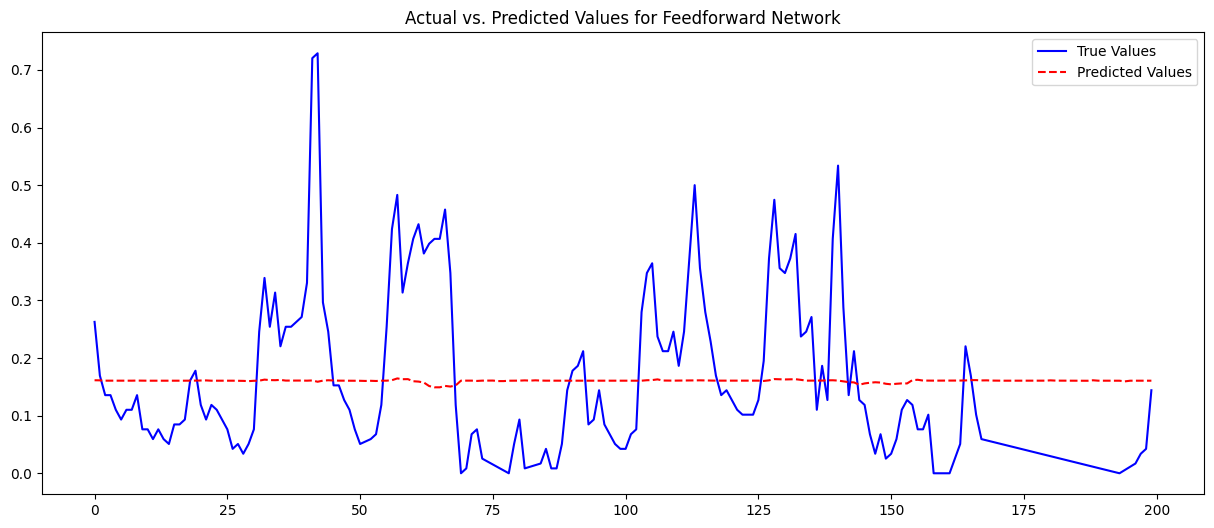

7/7 [==============================] - 1s 8ms/step


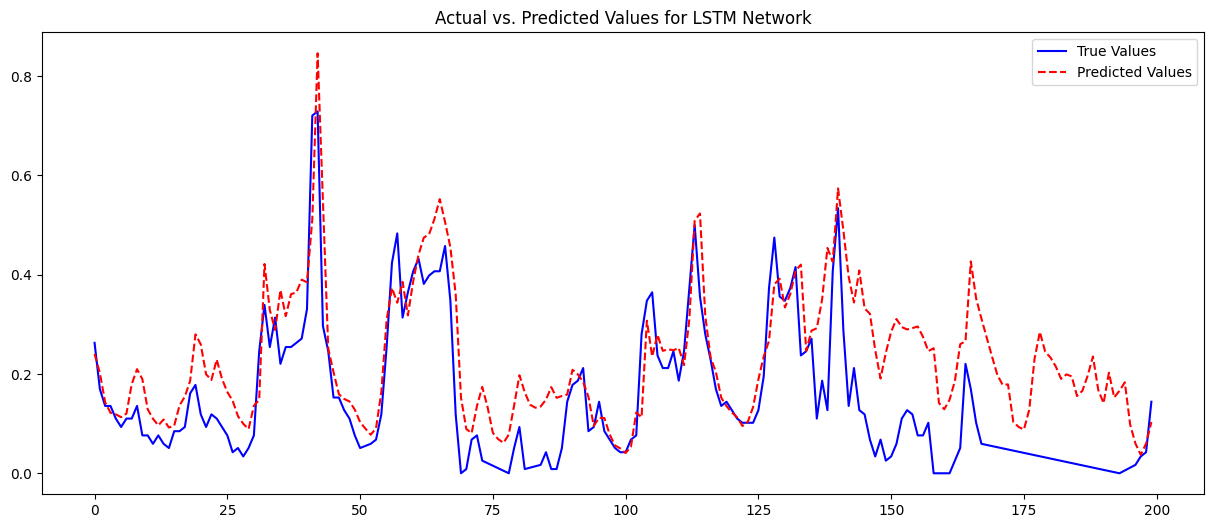

7/7 [==============================] - 1s 7ms/step


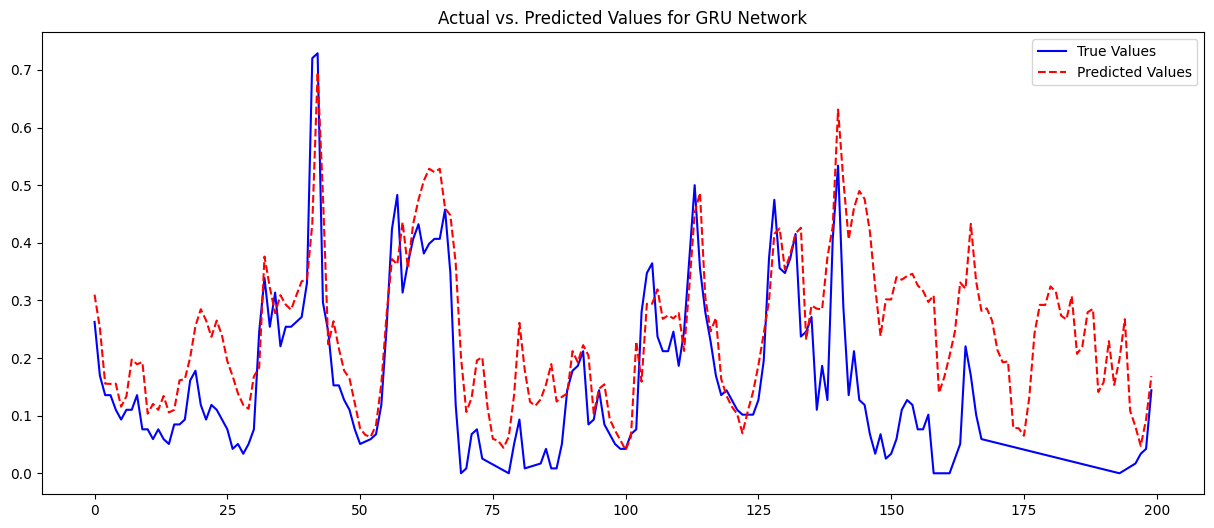

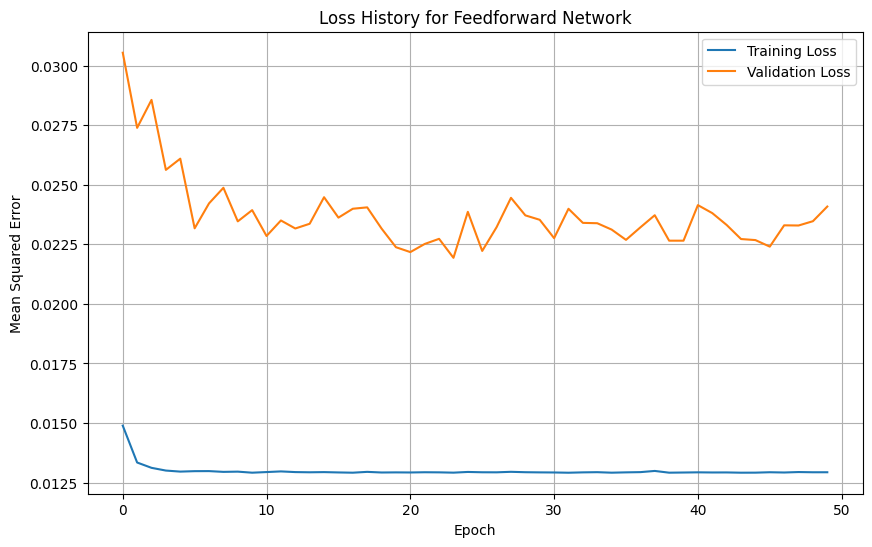

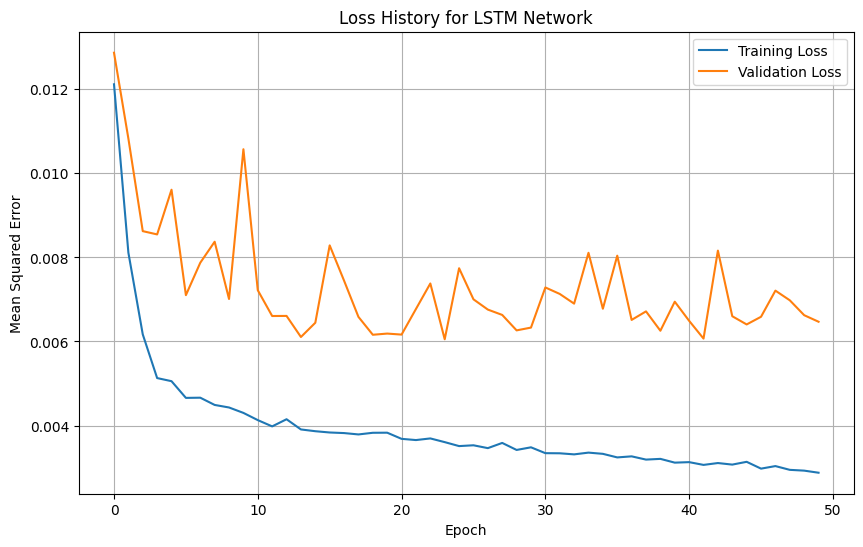

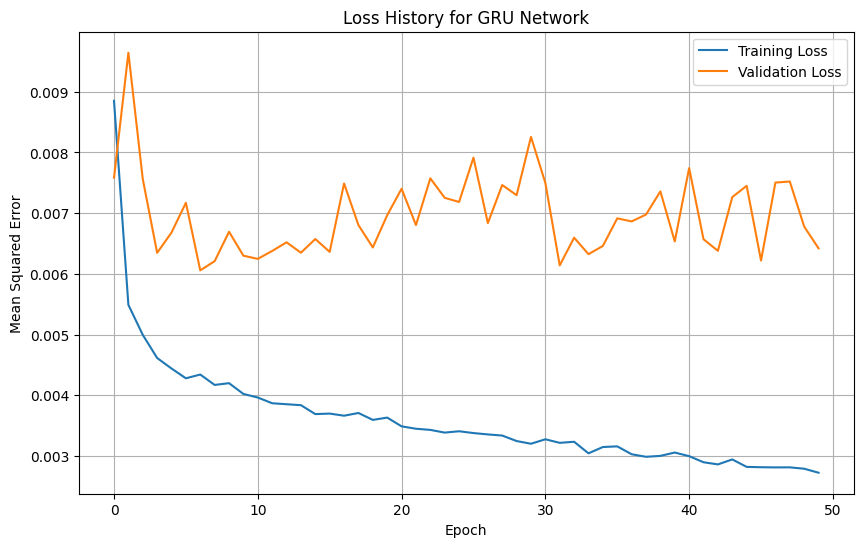

In [86]:

# Visualization
def plot_predictions(modelType, model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    if modelType == 'ff':
        y_pred = y_pred[:, -1, :]
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label="True Values", color="blue")
    plt.plot(y_pred, label="Predicted Values", color="red", linestyle="--")
    plt.title(f"Actual vs. Predicted Values for {model_name}")
    plt.legend()
    plt.show()

# Plot predictions for a subset of the test data
plot_limit = 200  # for visualization clarity, adjust as needed
plot_predictions('ff', model_ff, X_test[:plot_limit], y_test[:plot_limit], "Feedforward Network")
plot_predictions('lstm', model_lstm, X_test[:plot_limit], y_test[:plot_limit], "LSTM Network")
plot_predictions('gru', model_gru, X_test[:plot_limit], y_test[:plot_limit], "GRU Network")

# Visualize Loss History
def plot_loss(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss History for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_ff, "Feedforward Network")
plot_loss(history_lstm, "LSTM Network")
plot_loss(history_gru, "GRU Network")